# Links

Texts: [https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset](https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset)

Words: [https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)

# Import

In [289]:
class Params:
    MAX_LEN = 10
    vocab = " abcdefghijklmnopqrstuvwxyz" # 1-indexed
    char_to_index = {char: i for i, char in enumerate(vocab)}
    index_to_char = {i: char for i, char in enumerate(vocab)}

    @staticmethod
    def encode_string(s: str):
        return [Params.char_to_index[char] for char in s]

    @staticmethod
    def decode_string(encoded: list[int]):
        return ''.join([Params.index_to_char[i] for i in encoded if i != 0])

In [290]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch import tensor
from torch.functional import F
from torchvision import transforms


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skimage.morphology import skeletonize
from itertools import product

import pandas as pd
import numpy as np
import os
from PIL import Image
import copy
import cv2

from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data

In [291]:
with open('iam_words/words.txt', 'r') as f:
    words = f.readlines()
words = [word.strip() for word in words]
words = words[18:-1]
words = [w for w in words if ' err ' not in w]
words = [[w.split(' ')[0], w.split(' ')[-1]] for w in words]
words = [
    [f'iam_words/words/{w.split('-')[0]}/{w.split('-')[0]}-{w.split('-')[1]}/{w}.png', y] for w, y in words]
df = pd.DataFrame(words, columns=['filename', 'word'])
df = df[df['filename'].apply(os.path.exists)]
# Filter out rows where the file cannot be opened
# valid_rows = []
# for _, row in df.iterrows():
#     try:
#         with Image.open(row['filename']) as img:
#             img.verify()  # Verify that the file is a valid image
#         valid_rows.append(row)
#     except Exception as e:
#         print(f"Skipping file {row['filename']} due to error: {e}")

# df = pd.DataFrame(valid_rows, columns=df.columns)
df = df[df['word'].apply(lambda x: all(char in Params.vocab[1:] for char in x) and len(x) <= Params.MAX_LEN)]
df

,filename,word
2,iam_words/words/a01/a01-000u/a01-000u-00-02.png,to
3,iam_words/words/a01/a01-000u/a01-000u-00-03.png,stop
6,iam_words/words/a01/a01-000u/a01-000u-00-06.png,from
7,iam_words/words/a01/a01-000u/a01-000u-01-00.png,nominating
8,iam_words/words/a01/a01-000u/a01-000u-01-01.png,any
...,...,...
38300,iam_words/words/e07/e07-072/e07-072-08-07.png,be
38301,iam_words/words/e07/e07-072/e07-072-09-00.png,obtained
38302,iam_words/words/e07/e07-072/e07-072-09-01.png,at
38303,iam_words/words/e07/e07-072/e07-072-09-02.png,a


# Dataset

In [292]:
class HandWritingDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augument: bool = False):
        super().__init__()
        self.df = df
        self.augument = augument
        self.compose = transforms.Compose([
            transforms.RandomRotation(5, expand=True, fill=(255,)),
            transforms.RandomAffine(0, translate=(0.05, 0.05), fill=(255,)),
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx) -> tuple[tensor, tensor]:
        row = self.df.iloc[idx]
        im = Image.open(row['filename']).convert('L')
        if self.augument:
            im = self.compose(im)
        im = cv2.bitwise_not(np.array(im, dtype=np.uint8))
        im = cv2.resize(im, (64, 32), interpolation=cv2.INTER_CUBIC)
        # _, im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # im = skeletonize(im).astype(np.uint8)
        im = tensor(np.array(im, dtype=np.float32), dtype=torch.float32).to(device).unsqueeze(0) / 255.0
        label = tensor(Params.encode_string(row['word'])).to(device)
        if len(label) < Params.MAX_LEN:
            label = torch.cat([label, tensor([0] * (Params.MAX_LEN - len(label))).to(device)])

        return im, label

In [293]:
for x, y in DataLoader(HandWritingDataset(df.sample(200))):
    print(x.shape, y.shape)
    break

torch.Size([1, 1, 32, 64]) torch.Size([1, 10])


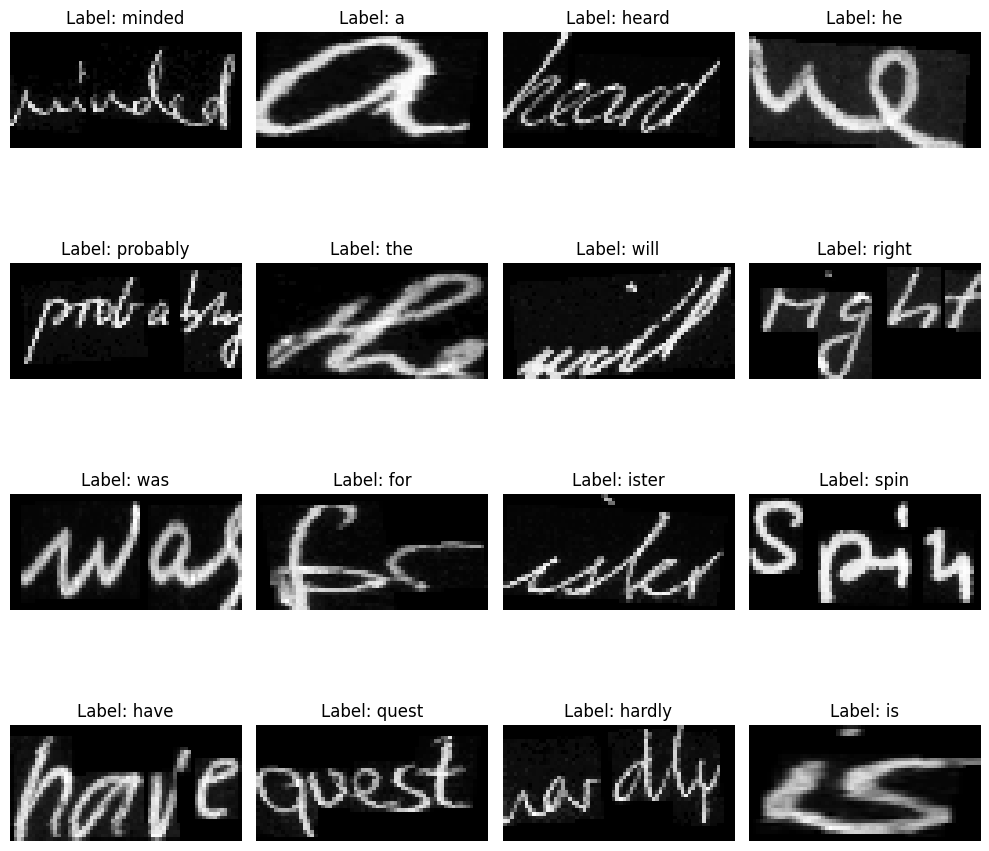

In [294]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (x, y) in enumerate(HandWritingDataset(df.sample(16), augument=True)):
    ax = axes[i // 4, i % 4]
    ax.imshow(x.squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {Params.decode_string(np.round(y.cpu().numpy(), 2))}")
plt.tight_layout()
plt.show()

# Loader

In [295]:
def getLoaders(df: pd.DataFrame, size: float = 1.0, batch_size: int = 4, not_train_size: float = 0.2) -> tuple[DataLoader, DataLoader, DataLoader]:
    tmpdf = df.sample(int(len(df) * size))

    train_df, test_df = train_test_split(tmpdf, test_size=not_train_size)
    test_df, val_df = train_test_split(test_df, test_size=0.5)
    
    train_dataset = HandWritingDataset(train_df, augument=True)
    test_dataset = HandWritingDataset(test_df)
    val_dataset = HandWritingDataset(val_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader, val_loader

# Model

In [296]:
class HandWritingModel(nn.Module):
    def __init__(self, c: int, h: int, n: int):
        super(HandWritingModel, self).__init__()

        self.conv1 = nn.Conv2d(1, c, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(c)
        self.drop1 = nn.Dropout(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=16*c, hidden_size=h, num_layers=n, batch_first=True)

        self.output = nn.Linear(h, len(Params.vocab))

        self._init_weights()

    def forward(self, x):
        # print(f"Input: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")
        if torch.isnan(x).any() or torch.isinf(x).any():
            raise ValueError("Input contains NaN or Inf values")

        x = self.conv1(x)
        # print(f"After conv1: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")
        # print(f"conv1 weights: min={self.conv1.weight.min().item()}, max={self.conv1.weight.max().item()}")
        # print(f"conv1 bias: min={self.conv1.bias.min().item()}, max={self.conv1.bias.max().item()}")

        x = self.norm1(x)
        # print(f"After norm1: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")
        # print(f"norm1 running mean: {self.norm1.running_mean}")
        # print(f"norm1 running var: {self.norm1.running_var}")

        x = F.relu(x)
        # print(f"After ReLU: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        x = self.drop1(x)
        # print(f"After dropout: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        x = self.pool1(x)
        # print(f"After pooling: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        x = x.permute(0, 3, 2, 1)
        # print(f"After permute: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        x = x.flatten(start_dim=2)
        x / x.max(dim=2, keepdim=True)[0]
        # print(f"After flatten: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        x, (_, _) = self.lstm(x)
        # print(f"After LSTM: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        x = self.output(x)
        # print(f"After output layer: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        x = x.permute(1, 0, 2)
        # print(f"After second permute: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        x = F.log_softmax(x + 1e-8, dim=2)
        # print(f"After log_softmax: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")

        return x
        
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)
                        # Initialize forget gate bias to 1
                        if 'bias_ih' in name:
                            n = param.size(0)
                            param.data[n // 4:n // 2].fill_(1.0)

# Training

In [297]:
def train_model(
    model: HandWritingModel, 
    criterion: nn.CTCLoss, 
    optimizer: optim.Optimizer, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    epochs: int = 10
) -> None:
    model.train()
    print(f'|         '*10, end='|\n')
    for epoch in range(epochs):
        train_losses = 0
        i = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)  # Shape: (T, batch_size, num_classes)

            batch_size = x.size(0)
            input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
            target_lengths = torch.tensor([len(seq[seq != 0]) for seq in y], dtype=torch.long).to(device)

            loss = criterion(y_pred, y, input_lengths, target_lengths)

            if any(target_lengths > input_lengths):
                raise ValueError("target_lengths cannot exceed input_lengths")
            
            if any(target_lengths == 0):
                raise ValueError("target_lengths contains zero-length sequences")
            
            if torch.isnan(x).any() or torch.isinf(x).any():
                raise ValueError("Input contains NaN or Inf values")

            if torch.isnan(loss):
                raise Exception("NaN loss detected")

            if i % max(1, len(train_loader.dataset) // (train_loader.batch_size * 100)) == 0:
                print('-', end='')

            train_losses += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            i += 1

        val_losses = 0
        with torch.no_grad():
            for x, y in val_loader:
                y_pred = model(x)  # Shape: (T, batch_size, num_classes)

                batch_size = x.size(0)
                input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
                target_lengths = torch.tensor([len(seq[seq != 0]) for seq in y], dtype=torch.long).to(device)

                loss = criterion(y_pred, y, input_lengths, target_lengths)

                if torch.isnan(loss):
                    raise Exception("NaN loss detected")
                val_losses += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses/len(train_loader):.3f}     Val_Loss: {val_losses/len(val_loader):.3f}")

In [307]:
def test_model(model: HandWritingModel, criterion: nn.CTCLoss, test_loader: DataLoader) -> float:
    model.eval()
    test_losses = 0
    for x, y in test_loader:
        y_pred = model(x)
        batch_size = x.size(0)
        input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
        target_lengths = torch.tensor([len(seq[seq != 0]) for seq in y], dtype=torch.long).to(device)
        loss = criterion(y_pred, y, input_lengths, target_lengths)
        test_losses += loss.sum().item()
        if torch.isnan(loss):
            raise Exception("NaN loss detected")
    return test_losses / len(test_loader) / test_loader.batch_size

In [314]:
def predict(model: HandWritingModel, sample_df) -> list[tuple[str, str]]:
    model.eval()
    predictions = []
    test_loader = DataLoader(HandWritingDataset(sample_df), batch_size=1, shuffle=False)
    with torch.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=2).cpu().numpy().flatten()
            y = y.cpu().numpy().flatten()
            predictions.append((Params.decode_string(y_pred), Params.decode_string(y)))
    return predictions

# Example usage

In [ ]:
criterion = nn.CTCLoss(blank=0).to(device)
model = HandWritingModel(64, 256, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

train_loader, test_loader, val_loader = getLoaders(df, size=1.0, batch_size=4, not_train_size=0.2)

|         |         |         |         |         |         |         |         |         |         |
-----------------------------------------------------------------------------------------------------Epoch 1/2, Loss: 2.851     Val_Loss: 2.476
-----------------------------------------------------------------------------------------------------Epoch 2/2, Loss: 2.285     Val_Loss: 1.973


In [320]:
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=4)

|         |         |         |         |         |         |         |         |         |         |
-----------------------------------------------------------------------------------------------------Epoch 1/4, Loss: 1.419     Val_Loss: 1.324
-----------------------------------------------------------------------------------------------------Epoch 2/4, Loss: 1.363     Val_Loss: 1.276
-----------------------------------------------------------------------------------------------------Epoch 3/4, Loss: 1.314     Val_Loss: 1.221
-----------------------------------------------------------------------------------------------------Epoch 4/4, Loss: 1.277     Val_Loss: 1.205


In [321]:
test_loss = test_model(model, criterion, test_loader)
print(f"Test Loss: {test_loss:.3f}")

Test Loss: 0.283


In [322]:
predictions = predict(model, df.sample(50))
for i in predictions:
    print(i)

('tff', 'if')
('war', 'was')
('thhe', 'the')
('tfff', 'of')
('crough', 'enough')
('wntther', 'another')
('hoote', 'more')
('teen', 'even')
('tannt', 'want')
('thot', 'that')
('se', 'be')
('ihhe', 'the')
('oor', 'for')
('siaatfiilee', 'woodfiller')
('tappad', 'tapped')
('tt', 'it')
('ooo', 'no')
('thhe', 'the')
('weiinngg', 'being')
('thhatt', 'that')
('mrropperrnly', 'property')
('tay', 'lay')
('stiiiee', 'strike')
('ann', 'on')
('mgeet', 'pages')
('thhee', 'the')
('tale', 'take')
('poblit', 'rabbit')
('innnn', 'in')
('tools', 'tools')
('t', 'up')
('widy', 'likely')
('pouarrrds', 'towards')
('thhat', 'that')
('whtes', 'sites')
('thee', 'the')
('tom', 'from')
('aleoddy', 'already')
('wctiios', 'actions')
('thhhee', 'the')
('gulsiiio', 'population')
('tff', 'of')
('offf', 'of')
('beiing', 'being')
('itt', 'it')
('tiidal', 'bridal')
('any', 'any')
('iast', 'last')
('auduriing', 'enduring')
('to', 'to')


# Tuning

In [ ]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True).to(device)

tested_parameters = list(product([16, 32, 64, 128], [64, 128, 256], [1, 2]))

train_loader, test_loader, val_loader = getLoaders(df, size=0.03, batch_size=4, not_train_size=0.2)

results = pd.DataFrame({
    'params': tested_parameters,
    'train_loss': 0.0,
    'test_loss': 0.0
})

for i in range(len(results)):
    row = results.iloc[i]
    print(f'c: {row["params"][0]}, h: {row["params"][1]}, n: {row["params"][2]}')
    model = HandWritingModel(row['params'][0], row['params'][1], row['params'][2]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_model(model, criterion, optimizer, train_loader, val_loader, epochs=1)
    results.loc[i, 'train_loss'] = test_model(model, criterion, train_loader)
    results.loc[i, 'test_loss'] = test_model(model, criterion, test_loader)

print(results)

c: 16, h: 64, n: 1
|         |         |         |         |         |         |         |         |         |         |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- Epoch 1/1, Loss: 5.220     Val_Loss: 1.095
c: 16, h: 64, n: 2
|         |         |         |         |         |         |         |         |         |         |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- Epoch 1/1, Loss: 4.667     Val_Loss: 1.139


KeyboardInterrupt: 

<Axes: xlabel='params'>

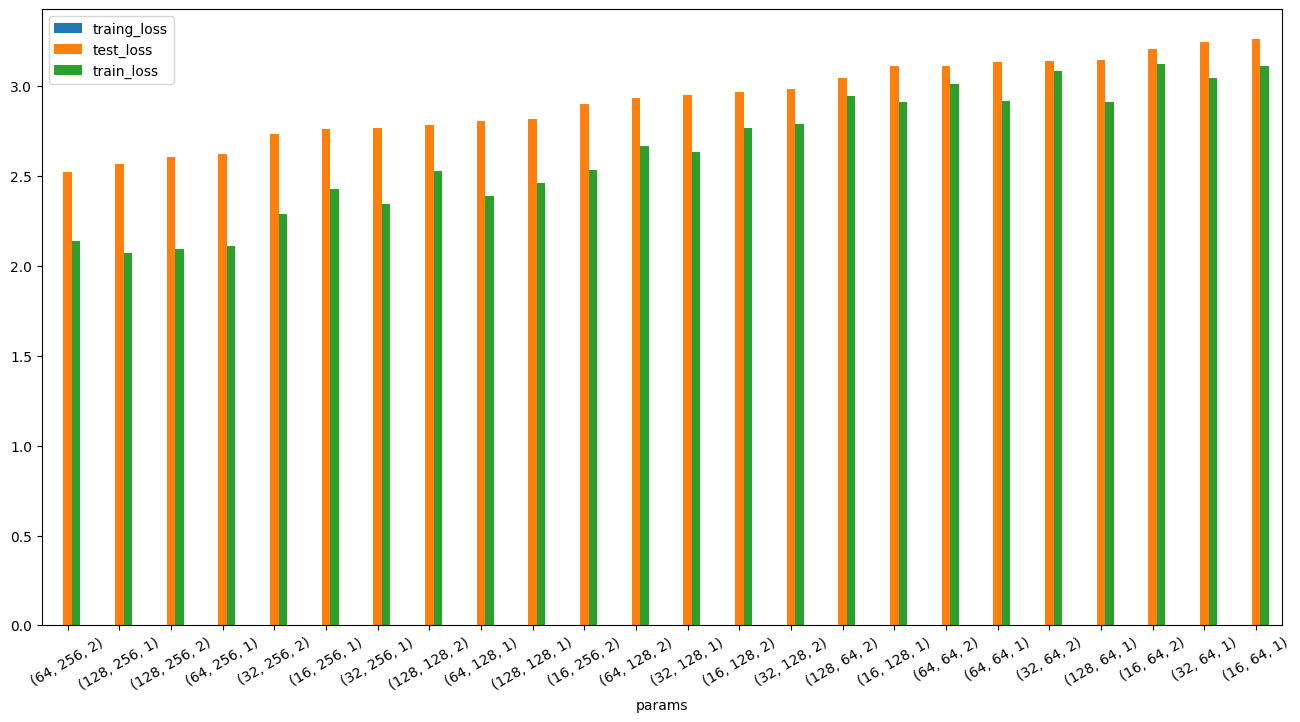

In [ ]:
results = results.sort_values(by='test_loss', ascending=True)

results.set_index('params').plot(kind='bar', figsize=(16, 8), rot=30)
